#Лабораторна робота №2. Bagging

**Виконала** студентка групи КІ-41мп Додонова Марія.

**Мета:** Ознайомлення із беггінгом - одним з підвидів ансамблевого навчання. Розуміти застосування Беггінгу та вплив типу машиного навчання на ефективність Беггінгу.

##Порядок виконання

1. В ході виконання роботи буде досліджено ефективність та особливості застосування беггінгу для побудови ансамблей для задачі класифікації. Вам необхідно використати щонайменше **2** слабкі класифікатори. Слабкі класифікатори обирати на свій розсуд, наприклад багатошаровий персептрон, опроно-векторні машини, дерева рішень тощо.
2. Обрати набір данних. Використовувати рекомендується аналітичні набори даних (можете взяти з попередньої лабораторної роботи).
3. Обрати методологію бутстрапінгу (**resampling with replacement / jacknife / poisson**)
4. Навчити слабкі класифікатори та їх ансамблеві варіанти. Всього в роботі необхідно буде дослідити **пʼять моделей** (див. Таблицю 1). Кількість класифікаторів та їх співвідношення (як і гіперпараметри моделі) - на ваш розсуд.
5. Заповнити таблицю 1 отриманими значеннями. Також рекомендється додати скріншоти метрик навчання у протокол.
6. Оформити отримані результати у протоколі.


Таблиця 1

| Модель                                     | Бутстрап | Average Accuracy <br> (test) | Average Accuracy <br> (validation) | Average Precision <br> (validation) | F1 score |
|--------------------------------------------|----------|-------------------------|------------------------------|--------------------------------|---------|
| Слабкий Класифікатор 1                     | jacknife |                         |                              |                                |         |
| Анамбль (Слабкий Класифікатор 1)           | jacknife |                         |                              |                                |         |
| Слабкий Класифікатор 2                     | jacknife |                         |                              |                                |         |
| Анамбль (Слабкий Класифікатор 2)           | jacknife |                         |                              |                                |         |
| Анамбль (Слабкий Класифікатор 1 <br> + Слабкий Класифікатор 2) |          |                         |                              |                                |         |


##Виконання роботи

Імпортуємо необхідні модулі та встановимо значення SEED для відтворюваності результатів. Оберемо аналітичний набір даних IRIS з попередньої лабораторної роботи. Завантажимо його та виконаємо попередню обробку даних. Розділимо набір на три частини: тренувальну (70%), валідаційну (15%) та тестову (15%) вибірки.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import numpy as np
import random

SEED = 42
BATCH_SIZE = 16

random.seed(SEED)
np.random.seed(SEED)
random_state = check_random_state(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

data = load_iris()
X, y = data.data, data.target

y = np.array([int(label) for label in y])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {X_train.shape[0]},",
      f"Validation size: {X_val.shape[0]},",
      f"Test size: {X_test.shape[0]}")

Train size: 105, Validation size: 22, Test size: 23


Створимо структуру для зберігання метрик Average Accuracy (test), Average Accuracy (validation), Average Precision (validation) та F1-score усіх моделей.

In [ ]:
table_data = {
    "Модель": [
        "Слабкий Класифікатор 1", "Анамбль (Слабкий Класифікатор 1)",
        "Слабкий Класифікатор 2", "Анамбль (Слабкий Класифікатор 2)",
        "Анамбль (Слабкий Класифікатор 1 + Слабкий Класифікатор 2)"
    ],
    "Бутстрап": ["jacknife"] * 5,
    "Average Accuracy (test)": [None] * 5,
    "Average Accuracy (validation)": [None] * 5,
    "Average Precision (validation)": [None] * 5,
    "F1 score": [None] * 5
}

Оберемо 2 слабкі класифікатори: дерево рішень та багатошаровий персептрон. Багатошаровий персептрон матиме 3 приховані шари, приховані активації ReLU та вихідну активацію Softmax.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(MLP, self).__init__()

    self.fc1 = nn.Linear(input_size, hidden_sizes[0])
    self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
    self.fc3 = nn.Linear(hidden_sizes[1], output_size)

    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)

    x = self.fc2(x)
    x = self.relu(x)

    x = self.fc3(x)
    x = self.softmax(x)

    return x

Напишемо функції для тренування та валідації багатошарового персептрона протягом однієї епохи. Обчислюватимемо в кожній метрику Accuracy.

In [ ]:
def train(model, optimizer, criterion, loader):
  model.train()
  correct, total = 0, 0

  for features, labels in loader:
    optimizer.zero_grad()
    outputs = model(features)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  accuracy = correct / total
  return accuracy

def validate(model, criterion, loader):
  model.eval()
  correct, total = 0, 0

  with torch.no_grad():
    for features, labels in loader:
      outputs = model(features)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = correct / total
  return accuracy

Також напишемо функцію для побудови графіка історії тренування багатошарових персептронів у ансамблі.

In [ ]:
import matplotlib.pyplot as plt

def plot_histories(train_histories, val_histories,
                   title="Ensemble MLP Training Progress"):
  plt.figure(figsize=(12, 6))
  colors = ["b", "g", "r", "c", "m", "y", "k", "orange", "lime", "purple"]

  for i in range(len(train_histories)):
    label = f"MLP {i}"
    color = colors[i % len(colors)]
    plt.plot(train_histories[i], linestyle="-", color=color,
             label=f"MLP {i+1} (train)")
    plt.plot(val_histories[i], linestyle="--", color=color,
             label=f"MLP {i+1} (val)")

  plt.xlabel("Epochs")
  plt.ylabel(f"Accuracy Value")
  plt.title(title)

  num_epochs = len(train_histories[0])
  tick_positions = np.arange(0, num_epochs, step=max(1, num_epochs // 10))
  tick_labels = [str(i+1) for i in tick_positions]
  plt.xticks(tick_positions, tick_labels)

  plt.legend(loc="best", fontsize=8)
  plt.grid(True)

  plt.show()

Визначимо клас ансамблю Беггінгу. За замовчуванням, використовується 5 дерев рішень та 5 багатошарових персептронів із прихованими шарами розмірів 16 та 12. Для навчання персептронів використовується 20 епох, оптимізатор Adam, швидкість навчання 0.001 та функція втрат CrossEntropyLoss. Максимальна глибина дерева рішень - 5.  Оберемо методологію бутстрапінгу resampling with replacement для ансамблю, що містить обидва види слабких класифікаторів, та jackknife для ансамблів, що складаються з лише з одного виду слабких класифікаторів.  
Оцінювання ансамблю проводитимемо за метриками accuracy (середня та ансамблева), precision (середня та ансамблева) f1-score (ансамблева).

In [ ]:
import torch.optim as optim
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, f1_score

class BaggingEnsemble:
  def __init__(self, num_dt=5, num_mlp=5, mlp_hidden_sizes=[16, 12],
               mlp_num_epochs=20, dt_max_depth=5, batch_size=16,
               learning_rate=0.001, resampling_method="jackknife"):
    self.num_dt = num_dt
    self.dt_max_depth = dt_max_depth
    self.num_mlp = num_mlp
    self.mlp_hidden_sizes = mlp_hidden_sizes
    self.mlp_num_epochs = mlp_num_epochs
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.resampling_method = resampling_method
    self.dt_classifiers = []
    self.mlp_classifiers = []
    self.mlp_train_history = []
    self.mlp_val_history = []

  def __resample_data(self, X, y, n_samples):
    if self.resampling_method == "replacement":
      samples, labels = [], []

      for i in range(n_samples):
        X_resampled, y_resampled = resample(X, y, replace=True)
        samples.append(X_resampled)
        labels.append(y_resampled)

      return samples, labels

    elif self.resampling_method == "jackknife":
      samples, labels = [], []
      random_indices = np.random.choice(len(X), n_samples, replace=False)

      for i in random_indices:
        X_resampled = np.delete(X, i, axis=0)
        y_resampled = np.delete(y, i, axis=0)
        samples.append(X_resampled)
        labels.append(y_resampled)

      return samples, labels

    else:
        raise ValueError("Unknown resampling method.")

  def __create_loader(self, X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    return loader

  def __train_mlp(self, X, y, val_loader):
    train_history, val_history = [], []
    input_size, output_size = X.shape[1], len(set(y))
    mlp = MLP(input_size, self.mlp_hidden_sizes, output_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=self.learning_rate)

    loader = self.__create_loader(X, y)

    for epoch in range(self.mlp_num_epochs):
      train_accuracy = train(mlp, optimizer, criterion, loader)
      val_accuracy = validate(mlp, criterion, val_loader)

      train_history.append(train_accuracy)
      val_history.append(val_accuracy)

    return mlp, train_history, val_history

  def fit(self, X_train, y_train, val_loader):
    n_samples = max(self.num_dt, self.num_mlp)
    X_resampled, y_resampled = self.__resample_data(
        X_train, y_train, n_samples)

    for i in range(self.num_dt):
      dt = DecisionTreeClassifier(max_depth=self.dt_max_depth,
                                  random_state=SEED)
      dt.fit(X_resampled[i], y_resampled[i])
      self.dt_classifiers.append(dt)

    for i in range(self.num_mlp):
      mlp, train_history, val_history = self.__train_mlp(
          X_resampled[i], y_resampled[i], val_loader)
      self.mlp_classifiers.append(mlp)
      self.mlp_train_history.append(train_history)
      self.mlp_val_history.append(val_history)

  def predict(self, X_test):
    dt_preds = np.array(
        [dt.predict(X_test) for dt in self.dt_classifiers]
    )

    mlp_preds = []
    for mlp in self.mlp_classifiers:
      y_pred = mlp(torch.tensor(X_test, dtype=torch.float32))
      y_pred = y_pred.argmax(dim=1).numpy()
      mlp_preds.append(y_pred)
    mlp_preds = np.array(mlp_preds)

    all_preds = np.vstack((dt_preds, mlp_preds))
    final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(),
                                      axis=0, arr=all_preds)
    return final_preds

  def evaluate(self, X_test, y_test):
    individual_accuracies, individual_precisions = [], []
    dt_preds, mlp_preds = [], []

    for dt in self.dt_classifiers:
      y_pred = dt.predict(X_test)
      dt_preds.append(y_pred)

      precision = precision_score(y_test, y_pred, average="weighted",
                                  zero_division=0)
      individual_precisions.append(precision)
      individual_accuracies.append(accuracy_score(y_test, y_pred))

    for mlp in self.mlp_classifiers:
      y_pred = mlp(torch.tensor(X_test, dtype=torch.float32))
      y_pred = y_pred.argmax(dim=1).numpy()
      mlp_preds.append(y_pred)

      precision = precision_score(y_test, y_pred, average="weighted",
                                  zero_division=0)
      individual_precisions.append(precision)
      individual_accuracies.append(accuracy_score(y_test, y_pred))

    all_preds = np.vstack((dt_preds + mlp_preds))
    final_preds = np.apply_along_axis(
        lambda x: np.bincount(x).argmax(), axis=0, arr=all_preds)

    ensemble_accuracy = accuracy_score(y_test, final_preds)
    ensemble_precision = precision_score(
        y_test, final_preds, average="weighted", zero_division=0)
    ensemble_f1 = f1_score(y_test, final_preds, average="weighted",
                           zero_division=0)

    result = {
        "average_accuracy": np.mean(individual_accuracies),
        "ensemble_accuracy": ensemble_accuracy,
        "average_precision": np.mean(individual_precisions),
        "ensemble_precision": ensemble_precision,
        "ensemble_f1_score": ensemble_f1
    }

    return result

Навчимо слабкі класифікатори та їх ансамблеві варіанти. Спершу виконаємо навчання слабкого класифікатора - дерева рішень.

In [ ]:
dt = DecisionTreeClassifier(max_depth=5, random_state=SEED)
dt.fit(X_train, y_train)

y_val_pred = dt.predict(X_val)
y_test_pred = dt.predict(X_test)

dt_test_accuracy = accuracy_score(y_test, y_test_pred)
dt_val_accuracy = accuracy_score(y_val, y_val_pred)
dt_val_precision = precision_score(y_val, y_val_pred,
                                   average="weighted", zero_division=0)
dt_f1_score = f1_score(y_val, y_val_pred, average="weighted",
                       zero_division=0)

table_data["Average Accuracy (test)"][2] = dt_test_accuracy
table_data["Average Accuracy (validation)"][2] = dt_val_accuracy
table_data["Average Precision (validation)"][2] = dt_val_precision
table_data["F1 score"][2] = dt_f1_score

print("Decision Tree Classifier Metrics")
print(f" Test Accuracy: {dt_test_accuracy:.4f}")
print(f" Val Accuracy: {dt_val_accuracy:.4f}")
print(f" Val Precision: {dt_val_precision:.4f}")
print(f" F1-score: {dt_f1_score:.4f}")

Decision Tree Classifier Metrics
 Test Accuracy: 0.9130
 Val Accuracy: 0.9091
 Val Precision: 0.9091
 F1-score: 0.9091


Проведемо навчання слабкого класифікатора - багатошарового персептрона.

Multilayer Perceptron Metrics
 Test Accuracy: 0.6522
 Val Accuracy: 0.6818
 Val Precision: 0.5227
 F1-score: 0.5758


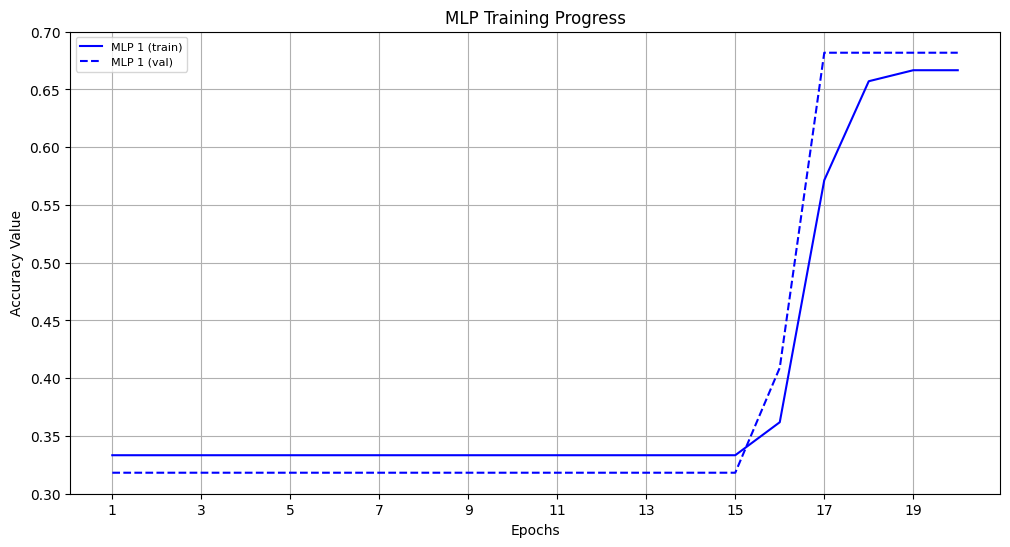

In [ ]:
train_history, val_history = [], []

mlp = MLP(4, [16, 12], 3)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
  train_accuracy = train(mlp, optimizer, criterion, train_loader)
  val_accuracy = validate(mlp, criterion, val_loader)

  train_history.append(train_accuracy)
  val_history.append(val_accuracy)

y_val_pred = mlp(torch.tensor(X_val, dtype=torch.float32))
y_val_pred = y_val_pred.argmax(dim=1).numpy()

y_test_pred = mlp(torch.tensor(X_test, dtype=torch.float32))
y_test_pred = y_test_pred.argmax(dim=1).numpy()

mlp_test_accuracy = accuracy_score(y_test, y_test_pred)
mlp_val_accuracy = accuracy_score(y_val, y_val_pred)
mlp_val_precision = precision_score(y_val, y_val_pred,
                                    average="weighted", zero_division=0)
mlp_f1_score = f1_score(y_val, y_val_pred, average="weighted",
                        zero_division=0)

table_data["Average Accuracy (test)"][0] = mlp_test_accuracy
table_data["Average Accuracy (validation)"][0] = mlp_val_accuracy
table_data["Average Precision (validation)"][0] = mlp_val_precision
table_data["F1 score"][0] = mlp_f1_score

print("Multilayer Perceptron Metrics")
print(f" Test Accuracy: {mlp_test_accuracy:.4f}")
print(f" Val Accuracy: {mlp_val_accuracy:.4f}")
print(f" Val Precision: {mlp_val_precision:.4f}")
print(f" F1-score: {mlp_f1_score:.4f}")

plot_histories([train_history], [val_history],
               title="MLP Training Progress")

Проведемо навчання ансамблю з 10 багатошарових персептронів.

Ensemble (MLP) Metrics
 Test Accuracy: 0.7043
 Val Accuracy: 0.7409
 Val Precision: 0.6949
 F1-score: 0.8144


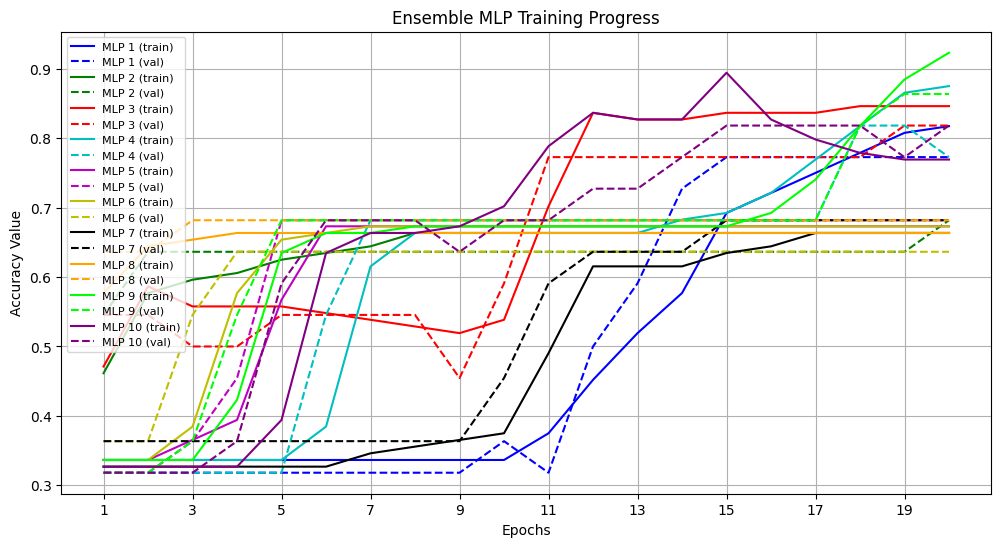

In [ ]:
ensemble_mlp = BaggingEnsemble(num_dt=0)
ensemble_mlp.fit(X_train, y_train, val_loader)
val_results = ensemble_mlp.evaluate(X_val, y_val)
test_results = ensemble_mlp.evaluate(X_test, y_test)

table_data["Average Accuracy (test)"][1] = test_results["average_accuracy"]
table_data["Average Accuracy (validation)"][1] = val_results["average_accuracy"]
table_data["Average Precision (validation)"][1] = val_results["average_precision"]
table_data["F1 score"][1] = val_results["ensemble_f1_score"]

print("Ensemble (MLP) Metrics")
print(f" Test Accuracy: {test_results['average_accuracy']:.4f}")
print(f" Val Accuracy: {val_results['average_accuracy']:.4f}")
print(f" Val Precision: {val_results['average_precision']:.4f}")
print(f" F1-score: {val_results['ensemble_f1_score']:.4f}")

plot_histories(ensemble_mlp.mlp_train_history,
               ensemble_mlp.mlp_val_history)

Проведемо навчання ансамблю з 10 дерев рішень.

In [ ]:
ensemble_dt = BaggingEnsemble(num_mlp=0)
ensemble_dt.fit(X_train, y_train, val_loader)
val_results = ensemble_dt.evaluate(X_val, y_val)
test_results = ensemble_dt.evaluate(X_test, y_test)

table_data["Average Accuracy (test)"][3] = test_results["average_accuracy"]
table_data["Average Accuracy (validation)"][3] = val_results["average_accuracy"]
table_data["Average Precision (validation)"][3] = val_results["average_precision"]
table_data["F1 score"][3] = val_results["ensemble_f1_score"]

print("Ensemble (DT) Metrics")
print(f" Test Accuracy: {test_results['average_accuracy']:.4f}")
print(f" Val Accuracy: {val_results['average_accuracy']:.4f}")
print(f" Val Precision: {val_results['average_precision']:.4f}")
print(f" F1-score: {val_results['ensemble_f1_score']:.4f}")

Ensemble (DT) Metrics
 Test Accuracy: 0.9348
 Val Accuracy: 0.8864
 Val Precision: 0.8903
 F1-score: 0.8629


Проведемо навчання ансамблю з 5 багатошарових персептронів та 5 дерев рішень. Оберемо методологію бутстрапінгу resampling with replacement у цьому випадку.

Ensemble (MLP + DT) Metrics
 Test Accuracy: 0.8130
 Val Accuracy: 0.8045
 Val Precision: 0.7948
 F1-score: 0.9091


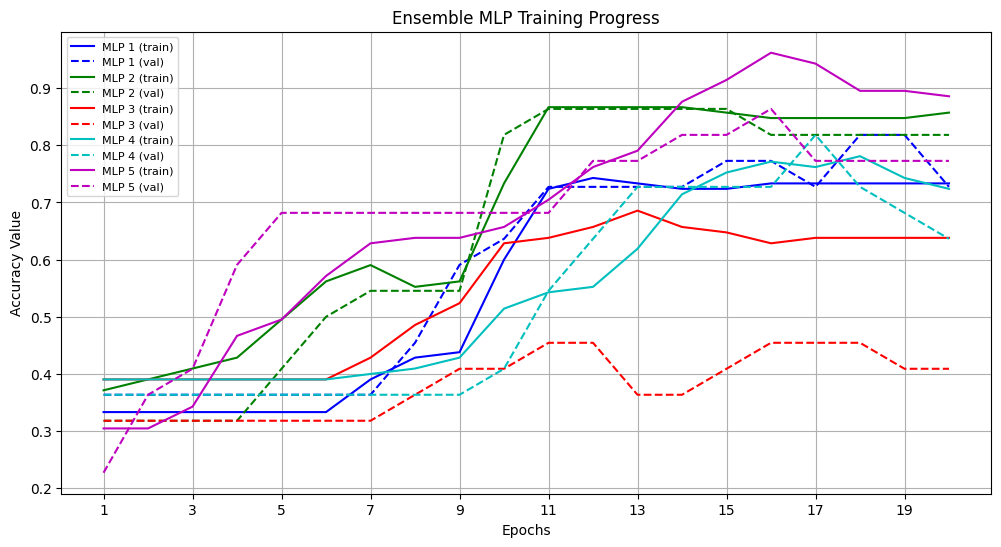

In [ ]:
ensemble_mlp_dt = BaggingEnsemble(num_dt=5, num_mlp=5, resampling_method="replacement")
ensemble_mlp_dt.fit(X_train, y_train, val_loader)
val_results = ensemble_mlp_dt.evaluate(X_val, y_val)
test_results = ensemble_mlp_dt.evaluate(X_test, y_test)

table_data["Бутстрап"][4] = "replacement"
table_data["Average Accuracy (test)"][4] = test_results["average_accuracy"]
table_data["Average Accuracy (validation)"][4] = val_results["average_accuracy"]
table_data["Average Precision (validation)"][4] = val_results["average_precision"]
table_data["F1 score"][4] = val_results["ensemble_f1_score"]

print("Ensemble (MLP + DT) Metrics")
print(f" Test Accuracy: {test_results['average_accuracy']:.4f}")
print(f" Val Accuracy: {val_results['average_accuracy']:.4f}")
print(f" Val Precision: {val_results['average_precision']:.4f}")
print(f" F1-score: {val_results['ensemble_f1_score']:.4f}")

plot_histories(ensemble_mlp_dt.mlp_train_history,
               ensemble_mlp_dt.mlp_val_history)

Заповнимо таблицю 1 отриманими значеннями.

In [ ]:
import pandas as pd
df = pd.DataFrame(table_data)
df

,Модель,Бутстрап,Average Accuracy (test),Average Accuracy (validation),Average Precision (validation),F1 score
0,Слабкий Класифікатор 1,jacknife,0.652174,0.681818,0.522727,0.575758
1,Анамбль (Слабкий Класифікатор 1),jacknife,0.704348,0.740909,0.694913,0.814394
2,Слабкий Класифікатор 2,jacknife,0.913043,0.909091,0.909091,0.909091
3,Анамбль (Слабкий Класифікатор 2),jacknife,0.934783,0.886364,0.890278,0.862937
4,Анамбль (Слабкий Класифікатор 1 + Слабкий Клас...,replacement,0.813043,0.804545,0.794848,0.909091


Аналіз отриманих результатів показує суттєві відмінності між продуктивністю багатошарового персептрона, дерева рішень (Decision Tree) та їх ансамблів.

По-перше, окремий багатошаровий персептрон демонструє найгірші результати серед усіх моделей, що пояснюється складністю його навчання на малому наборі даних IRIS. Він досягає середньої тестової точності 0.652 та валідаційної 0.682. Те, що точність почала різко зростати лише після 15 епохи, може свідчити про необхідність більшої кількості епох для кращого навчання. При цьому його середня точність під час валідації є нижчою за аналогічні показники дерева рішень, а F1-метрика (0.575) свідчить про погане балансування між precision та recall.

Ансамбль, що складався з багатошарових персептронів, демонструє покращення показників у порівнянні з одиничним персептроном: тестова точність зросла до 0.702, а валідаційна – до 0.741. Cередня точність під час валідації (0.695) та F1-метрика (0.814) показують, що ансамблювання допомогло згладити проблеми окремих моделей, хоча розкид точності серед окремих персептронів залишається значним (від 0.63 до 0.91).

Дерево рішень значно перевершує багатошаровий персептрон за всіма метриками: тестова точність – 0.913, валідаційна – 0.909, середнє precision – 0.909, а F1-метрика – 0.909. Це свідчить про здатність дерева рішень адаптуватися до малих вибірок, на відміну від багатошарового персептрона, який вимагає великої кількості даних для якісного навчання.

Ансамбль дерев рішень показує незначне покращення у порівнянні з окремим деревом: тестова точність зросла до 0.935, хоча валідаційна точність знизилася до 0.886, а F1-метрика впала до 0.863. Це може свідчити про перенавчання.

Змішаний ансамбль (5 багатошарових персептронв та 5 дерев рішень) демонструє компроміс між двома підходами: його тестова точність – 0.813, валідаційна – 0.805, середнє precision – 0.795, F1 – 0.909. Ці результати свідчать про те, що метод resampling with replacement сприяє ефективнішому розподілу даних для навчання. Однак розкид точності персептронів у межах ансамблю (від 0.4 до 0.9) може свідчити про те, що частина з них залишалася слабкими навіть після навчання.

У підсумку, найбільш ефективними моделями виявилися дерево рішень та його ансамбль. Багатошаровий персептрон продемонстрував нижчі результати через обмежену кількість даних та потребу в довшому навчанні. Змішаний ансамбль забезпечив збалансовані показники, проте не перевершив ефективність ансамблю дерев рішень. Це свідчить про те, що для малих наборів даних варто використовувати моделі, які можуть швидко навчатися без великої потреби в епохах, такі як дерева рішень.


##Висновок

У цій лабораторній роботі було досліджено ефективність багатошарового персептрона та дерева рішень як окремих слабких класифікаторів, а також їх комбінацій у ансамблях на малому датасеті IRIS. Для створення ансамблів  було застосовано бутстрап-методи jackknife та resampling with replacement.

За результатами експериментів, дерево рішень показало найвищу точність серед окремих моделей, але ансамбль дерев дав лише незначне покращення результатів. Багатошаровий персептрон демонстрував нестабільні результати. Ансамбль багатошарових персептронів дає кращі результати, особливо за метрикою F1. Найкращі результати загалом були отримані у випадку ансамблю дерев рішень. Змішаний ансамбль, що об’єднує багатошарові персептрони та дерева рішень, може виявитися корисним у випадках, коли важливо отримати збалансовану продуктивність різних моделей та компенсувати їхні недоліки.